数据集加载完成！
开始训练...
Epoch 1/10: Train Loss: 0.1689, Train Acc: 0.950, Test Acc: 0.985
Epoch 2/10: Train Loss: 0.0488, Train Acc: 0.985, Test Acc: 0.985
Epoch 3/10: Train Loss: 0.0328, Train Acc: 0.990, Test Acc: 0.988
Epoch 4/10: Train Loss: 0.0229, Train Acc: 0.993, Test Acc: 0.989
Epoch 5/10: Train Loss: 0.0177, Train Acc: 0.994, Test Acc: 0.989
Epoch 6/10: Train Loss: 0.0063, Train Acc: 0.998, Test Acc: 0.992
Epoch 7/10: Train Loss: 0.0041, Train Acc: 0.999, Test Acc: 0.992
Epoch 8/10: Train Loss: 0.0032, Train Acc: 0.999, Test Acc: 0.991
Epoch 9/10: Train Loss: 0.0026, Train Acc: 1.000, Test Acc: 0.992
Epoch 10/10: Train Loss: 0.0021, Train Acc: 1.000, Test Acc: 0.992

训练总耗时：244.94 秒（约 4.08 分钟）


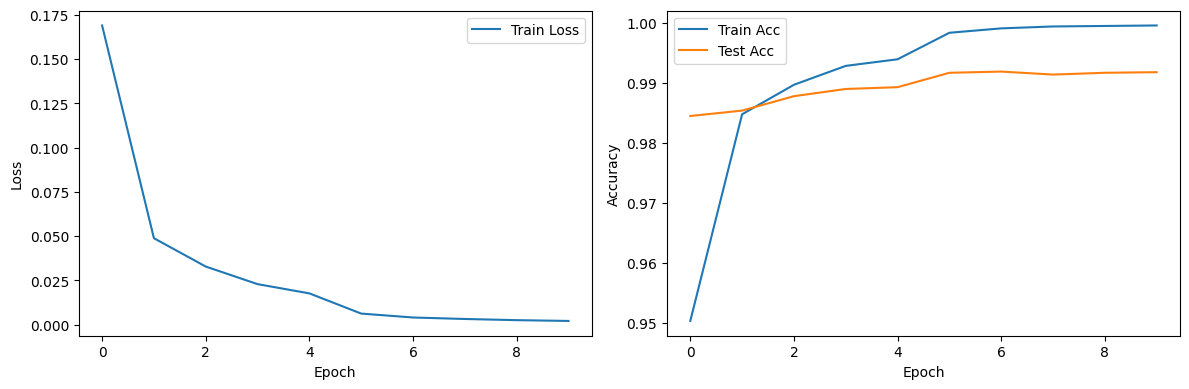

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time  # 新增

# 1. 加载MNIST数据集，并返回训练集和测试集的数据加载器
def load_data_mnist(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)
    print("数据集加载完成！")
    return (
        DataLoader(train_data, batch_size, shuffle=True, num_workers=2),
        DataLoader(test_data, batch_size, shuffle=False, num_workers=2)
    )

# 2. 模型定义 - 卷积神经网络模型
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)  # 输入通道1，输出通道10，卷积核5x5
        self.conv2 = nn.Conv2d(10, 20, 3) # 输入通道10，输出通道20，卷积核3x3
        self.fc1 = nn.Linear(20 * 10 * 10, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = torch.relu(out)
        out = torch.max_pool2d(out, 2, 2)
        out = self.conv2(out)
        out = torch.relu(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.fc2(out)
        return out

# 3. 训练模型，使用Adam和学习率调度器进行超参数优化
def train_model(net, train_iter, test_iter, num_epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    train_loss_list, train_acc_list, test_acc_list = [], [], []
    print("开始训练...")

    start_time = time.time()  # 计时开始

    for epoch in range(num_epochs):
        net.train()
        total_loss, total_correct, total_samples = 0, 0, 0

        for X, y in train_iter:
            output = net(X)
            loss = criterion(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (output.argmax(dim=1) == y).sum().item()
            total_samples += y.size(0)

        train_loss = total_loss / len(train_iter)
        train_acc = total_correct / total_samples

        net.eval()
        test_correct, test_samples = 0, 0
        with torch.no_grad():
            for X, y in test_iter:
                output = net(X)
                test_correct += (output.argmax(dim=1) == y).sum().item()
                test_samples += y.size(0)
        test_acc = test_correct / test_samples

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.3f}, '
              f'Test Acc: {test_acc:.3f}')

        scheduler.step()

    end_time = time.time()  # 计时结束
    elapsed = end_time - start_time
    print(f"\n训练总耗时：{elapsed:.2f} 秒（约 {elapsed / 60:.2f} 分钟）")

    # 可视化训练过程
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(test_acc_list, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    torch.manual_seed(42)
    batch_size = 128  # 改小批量
    num_epochs = 10
    learning_rate = 0.001  # 改小学习率，适合Adam

    train_iter, test_iter = load_data_mnist(batch_size)
    model = ConvNet()
    train_model(model, train_iter, test_iter, num_epochs, learning_rate)
